# Cell segmentation

The task is to segment nuclei from the background in different images.
The data can be downladed from https://www.kaggle.com/c/data-science-bowl-2018

## PART A. Image preprocessing

In [2]:
# Import necessary libraries
import os
import glob
import keras
from os.path import join
import cv2
%matplotlib notebook
import skimage
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import skimage.transform
from tqdm import tqdm
from subprocess import check_output
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from skimage.color import rgb2gray
from numpy import newaxis
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### 1. Read images

In [3]:
# The training images are in Stage1_train/imageid/images/*png
# Note that there is a csv with the encoded pixels but it is redundant since there are image masks
training_path = 'Stage1_train'
training_ids = os.listdir(training_path) # subdirectories
# whole path
training_image_paths=[glob.glob(join(training_path, test_id, "images", "*"))[0] for test_id in training_ids]

In [4]:
# The masks are in Stage1_train/imageid/masks/*png
training_image_mask_paths=[glob.glob(join(training_path, test_id, "masks", "*png"))[0] for test_id in training_ids]
#check an individual path name
training_image_mask_paths[1]

'Stage1_train/c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932/masks/ea92a0943e7f769e75fb89445bd04849e3f24729fc3b0b6604750b24c59c1e4f.png'

### 2.Collect separate cell masks and create whole masks for each image

Each image has several masks that depict each cell (submasks). We will write a function that collects
each of this submasks per image and creates a master mask that includes all the blobs for each images.
The images have uneven sizes, so the function will also resize the image before training the model.

In [5]:
# function that takes a string of the whole path of each image and has output 
# two images: the original and the mask image that includes all the individual masks
# for the particular image id. It also resizes both images because the original images
# have uneven dimensions
def image_mask_resize(image_id,image_height,image_width):
    image_file = "Stage1_train/{}/images/{}.png".format(image_id,image_id)
    mask_file = "Stage1_train/{}/masks/*.png".format(image_id)
    image_all_channels = skimage.io.imread(image_file)
    image = image_all_channels[:,:,:im_channels]
    img = cv2.resize(image, (image_height, image_width), interpolation = cv2.INTER_NEAREST)
    #the following commands collects all masks for the same image id
    masks = skimage.io.imread_collection(mask_file).concatenate() 
    height, width, _ = image.shape
    num_masks = masks.shape[0] # how many masks for this image_id
    labels = np.zeros((height, width), np.uint16) # initialize an image with the same size
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1 # each blob has an index number
    lbl = resize(labels, (image_height, image_width), mode='constant')# changes to range 0-1
    return img,lbl

In [6]:
img_width=128
img_height=128
im_channels=3
image1,labels1=image_mask_resize(training_ids[1],img_height,img_width)
image2,labels2=image_mask_resize(training_ids[2],img_height,img_width)
print(image2.dtype)
print(labels2.dtype)

uint8
float64


In [7]:
print(image2.shape)
print(labels2.shape)

(128, 128, 3)
(128, 128)


<IPython.core.display.Javascript object>


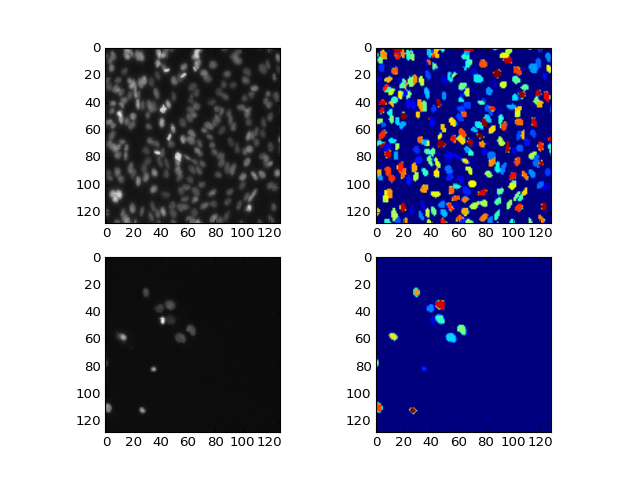

In [8]:
# Check the result of the function, image and mask
plt.subplot(221)
plt.imshow(image1)
plt.subplot(222)
plt.imshow(labels1)
plt.subplot(223)
plt.imshow(image2)
plt.subplot(224)
plt.imshow(labels2)

Use the function in all images and create new arrays that will be:

a. X_new, actual image in 3 colors and resized so the dimensions are height,width,channels.
   The values are 0-255.

b. Y_new is the mask image that has values either zero (background) or 1(cell). 
   The dimensions will be height,width,1

In [9]:
X_new = np.zeros((len(training_ids), img_height, img_width, im_channels),np.uint8) 
Y_new = np.zeros((len(training_ids), img_height, img_width,1)) # added 1 dimension so it has 3 dimensions

# Change all images and masks to the desired size
for n, id_img in tqdm(enumerate(training_ids), total=len(training_ids)):
    #print(n)
    #print(id_img)
    new_image, new_mask = image_mask_resize(id_img,img_height,img_width)
    X_new[n] = new_image
    new_mask[new_mask > 0] = 1 # all values >0 are now turned to 1
    new_mask = new_mask[:, :, newaxis]
    Y_new[n] = new_mask

100%|██████████| 670/670 [01:30<00:00,  7.38it/s]


In [10]:
Y_new[100].shape

(128, 128, 1)

<IPython.core.display.Javascript object>


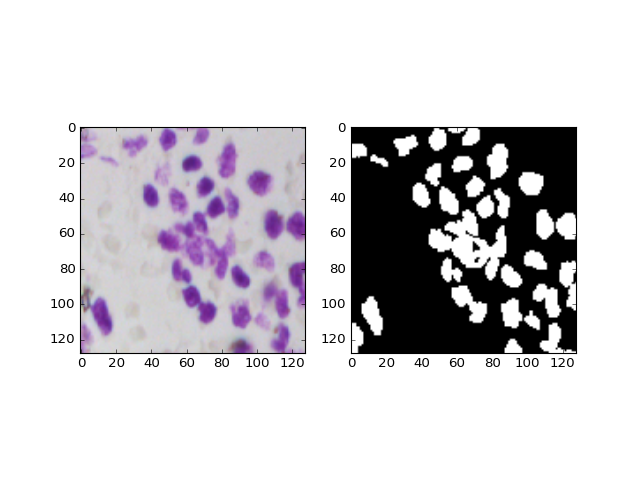

In [13]:
plt.subplot(121)
plt.imshow(X_new[100])
plt.subplot(122)
plt.imshow(np.squeeze(Y_new[100]),cmap='gray')

## PART B. Define the UNet architecture and the metric

In [14]:
# Define the metric iou
def mean_metric_iou(ytrue, ypred):
    prec = []
    for j in np.arange(0.5, 1.0, 0.05):
        ypred_ = tf.to_int32(ypred > j)
        score, up_opt = tf.metrics.mean_iou(ytrue, ypred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#### The UNet architecture has 3 parts:
a. Downsampling

b. Bottleneck

c. Upsampling

In [16]:
# UNet architecture
def unet(pretrained_weights = None,input_size = (128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [mean_metric_iou])

    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



## PART C. Image enhancement

We will try different methods to enhance the contrast and improve the balance of the images before the training.

### 1. Color images to grayscale

In [17]:
from PIL import Image
import cv2
# The function turns RGB images to grayscale
# (if the image is already grey no changes happen)
def color_to_grey(image):
    if len(image.shape)==3:
        assert(image.shape[2]==3) # to ensure 3 colors
        
        out_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
         
        out_image = image
    return out_image    

(128, 128, 3)
(128, 128)


<IPython.core.display.Javascript object>


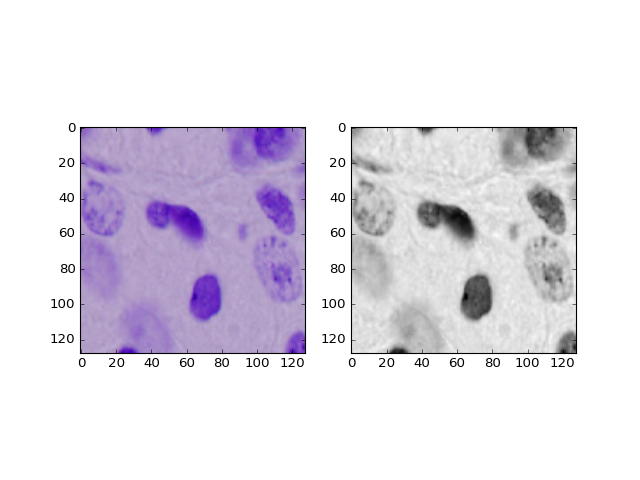

In [18]:
# Test the function
image_test = X_new[160,:,:,:]
image_grey = color_to_grey(image_test)
print(image_test.shape)
print(image_grey.shape)
plt.subplot(121)
plt.imshow(image_test)
plt.subplot(122)
plt.imshow(image_grey, cmap='gray')

In [19]:
print(image_grey.dtype)

uint8


In [20]:
# All color images to grayscale

num_of_images=X_new.shape[0]
# image dimensions
shape1=X_new.shape[1]
shape2=X_new.shape[2]

grayscl=np.empty(shape=[num_of_images, shape1, shape2,1],dtype=np.uint8)

for i in range(num_of_images):

    gr_image=color_to_grey(X_new[i,:,:,:])
    grayscl[i,:,:,0]=gr_image

### 2. Equalization

In [21]:
# create a function that will standardize a greyscale image globally and have all positive values from 0 to 1
def psglobal(image):
    # This works for grayscale so either has 2 dimensions or the third dimension is 1
    if len(image.shape)==2 or image.shape[2] == 1:
        img=image.astype('float64')
        nmean = np.mean(img)
        nstd  = np.std(img)
        global_pix = (img - nmean) / nstd
        # clip pixel values to [-1,1]
        image_clip = np.clip(global_pix, -1.0, 1.0)
        # shift from [-1,1] to [0,1] 
        image_norm = (image_clip + 1.0) / 2.0
        return image_norm

<IPython.core.display.Javascript object>


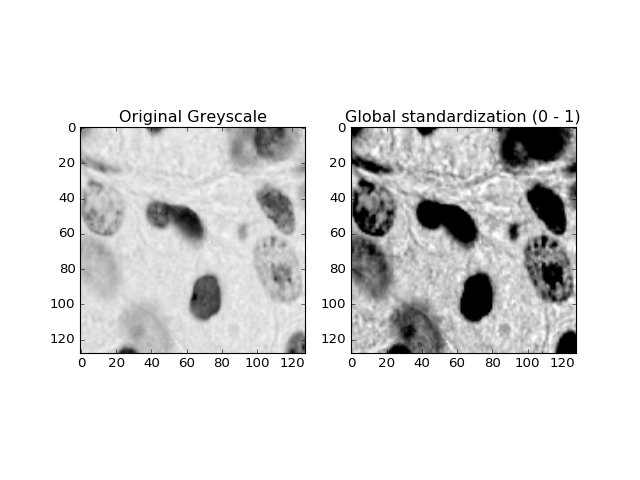

In [22]:
# Test the function
image_eq=psglobal(image_grey)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(image_grey,cmap='gray')
ax1.title.set_text('Original Greyscale')
ax2.imshow(image_eq, cmap='gray')
ax2.title.set_text('Global standardization (0 - 1)')
plt.show()

In [23]:
# Apply the function to all images
num_of_images=X_new.shape[0]
# dimensions
shape1=X_new.shape[1]
shape2=X_new.shape[2]

global_eq1=np.empty(shape=[num_of_images, shape1, shape2],dtype=np.float64)

for i in range(num_of_images):
    gray_image = color_to_grey(X_new[i,:,:,:]) 
    global_equal1=psglobal(gray_image)
    global_eq1[i,:,:]=global_equal1

# Add a 4th dimension so that it matches the masks
global_images=np.reshape(global_eq1,[670,128,128,1])

<IPython.core.display.Javascript object>


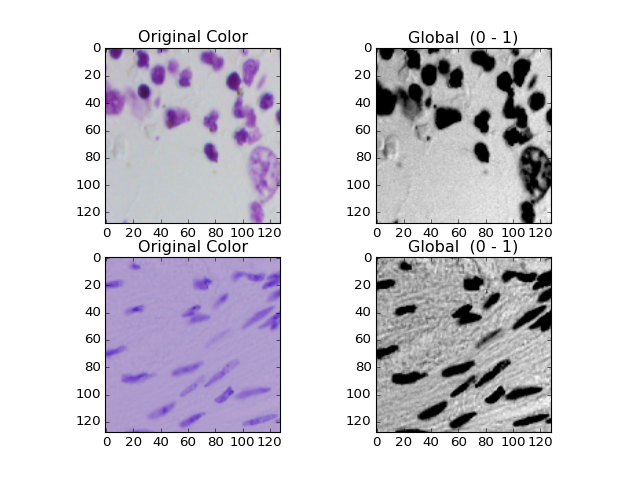

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(X_new[436,:,:,:])
ax1.title.set_text('Original Color')
ax2.imshow(global_eq1[436,:,:], cmap='gray')
ax2.title.set_text('Global  (0 - 1)')
ax3.imshow(X_new[390,:,:,:])
ax3.title.set_text('Original Color')
ax4.imshow(global_eq1[390,:,:], cmap='gray')
ax4.title.set_text('Global  (0 - 1)')
plt.show()

### 3. Contrast Limited Adaptive Histogram Equalization (CLAHE)

In [25]:
def histo_clahe(img,gridsz):
#This function takes an image and performs an adaptive histogram equalization on it
#gridsz is the tile grid size (neighborhood)

    assert(len(img.shape)==2)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(gridsz,gridsz))
    clahe_image = clahe.apply(img)
    return clahe_image

<IPython.core.display.Javascript object>


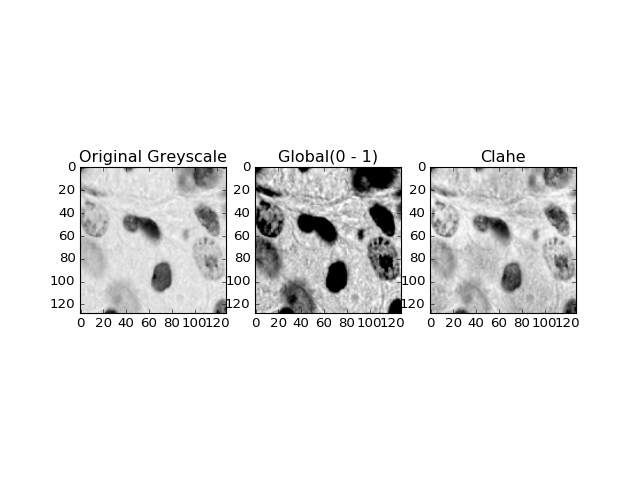

In [26]:
# Test the function 
new_clahe=histo_clahe(image_grey,8)
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(image_grey,cmap='gray')
ax1.title.set_text('Original Greyscale')
ax2.imshow(image_eq, cmap='gray')
ax2.title.set_text('Global(0 - 1)')
ax3.imshow(new_clahe,cmap='gray')
ax3.title.set_text('Clahe')
plt.show()

In [27]:
# Apply CLAHE to all images
clahe_image=np.empty(shape=[num_of_images, shape1, shape2],dtype=np.uint8)        

for j in range(num_of_images):
    gr_image = color_to_grey(X_new[j,:,:,:]) 
    cl_histo=histo_clahe(gr_image,16)
    clahe_image[j,:,:]=cl_histo

clahe_images=np.reshape(clahe_image,[num_of_images,shape1,shape2,1])

<IPython.core.display.Javascript object>


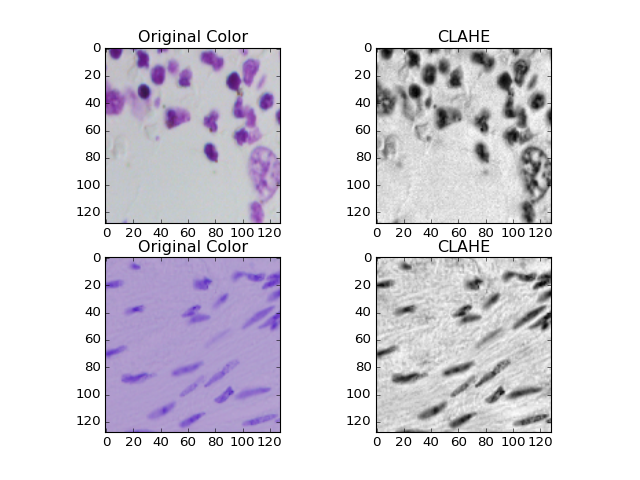

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(X_new[436,:,:,:])
ax1.title.set_text('Original Color')
ax2.imshow(clahe_image[436,:,:], cmap='gray')
ax2.title.set_text('CLAHE')
ax3.imshow(X_new[390,:,:,:])
ax3.title.set_text('Original Color')
ax4.imshow(clahe_image[390,:,:], cmap='gray')
ax4.title.set_text('CLAHE')
plt.show()

### 4. Combine of CLAHE and equalization

In [29]:
# Combine the previous functions
# Apply CLAHE to all equalized the images

clahe_global=np.empty(shape=[num_of_images, shape1, shape2,1],dtype=np.float64)

for i in range(num_of_images):

    clahe_and_global=psglobal(global_eq1[i,:,:])
    clahe_global[i,:,:,0]=clahe_and_global

<IPython.core.display.Javascript object>


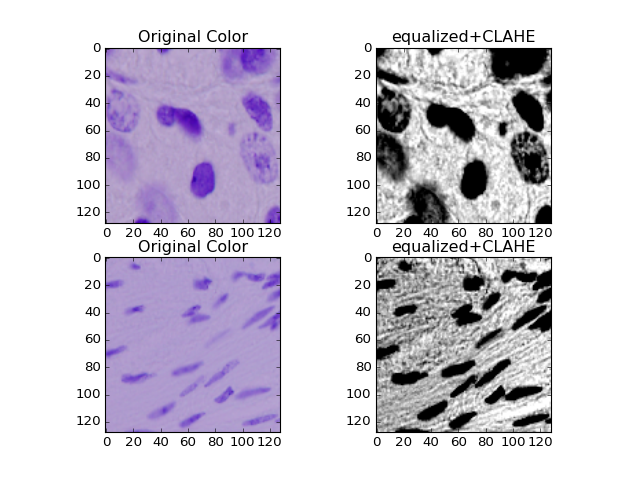

In [30]:
#Check the results
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(X_new[160,:,:,:])
ax1.title.set_text('Original Color')
ax2.imshow(clahe_global[160,:,:,0], cmap='gray')
ax2.title.set_text('equalized+CLAHE')
ax3.imshow(X_new[390,:,:,:])
ax3.title.set_text('Original Color')
ax4.imshow(clahe_global[390,:,:,0], cmap='gray')
ax4.title.set_text('equalized+CLAHE')
plt.show()

<IPython.core.display.Javascript object>


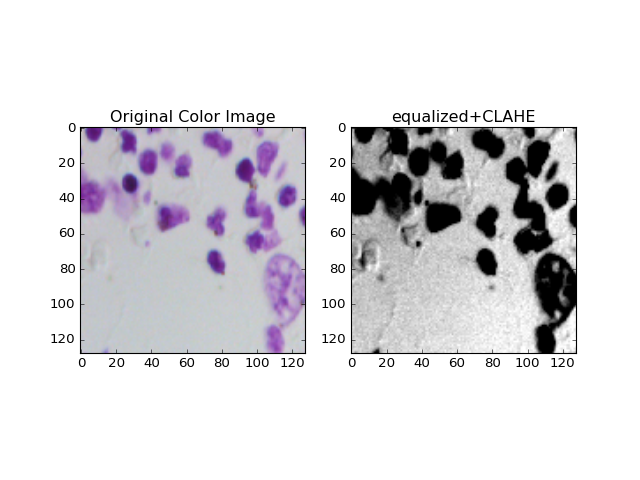

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(X_new[436,:,:,:])
ax1.title.set_text('Original Color Image')
ax2.imshow(clahe_global[436,:,:,0], cmap='gray')
ax2.title.set_text('equalized+CLAHE')

### 5. Rolling ball

In [32]:
# Corrects uneven illumination
import scipy.ndimage as scim
from skimage.morphology import ball

def rolling_ball(image,size):
    # size : specifies the structuring element neighborhood, depends on the cells
    # Create 3D ball structure
    s1 = ball(size)
    h1 = int((s1.shape[1] + 1) / 2)
    # Flatten the 3D ball to a 2D disc
    s1 = s1[:h1, :, :].sum(axis=0)
    # Rescale weights to 0-255 values
    s1 = (255 * (s1 - s1.min())) / (s1.max()- s1.min())
    # Use im-opening(im,ball) (white tophat transform)
    im_corrected = scim.white_tophat(image, structure=s1)
    return im_corrected  

<IPython.core.display.Javascript object>


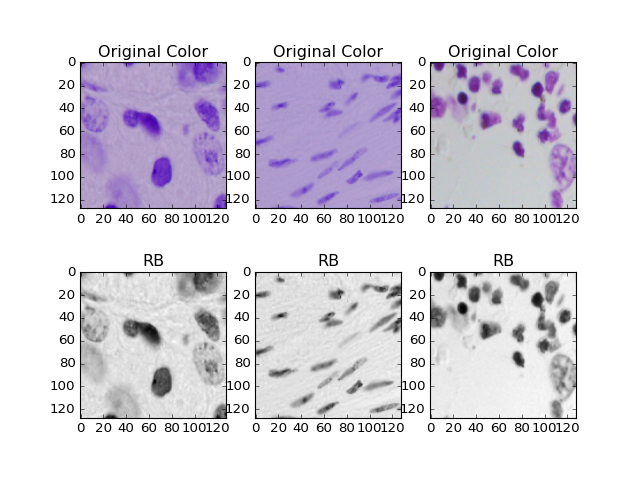

In [33]:
# Test the function
L1=color_to_grey(X_new[160,:,:,:])
L2=color_to_grey(X_new[390,:,:,:])
L3=color_to_grey(X_new[436,:,:,:])
corr1=rolling_ball(L1,25)
corr2=rolling_ball(L2,25)
corr3=rolling_ball(L3,25)
fig = plt.figure()
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
ax1.imshow(X_new[160,:,:,:])
ax1.title.set_text('Original Color')
ax2.imshow(X_new[390,:,:,:])
ax2.title.set_text('Original Color')
ax3.imshow(X_new[436,:,:,:])
ax3.title.set_text('Original Color')
ax4.imshow(corr1, cmap='gray')
ax4.title.set_text('RB')
ax5.imshow(corr2, cmap='gray')
ax5.title.set_text('RB')
ax6.imshow(corr3, cmap='gray')
ax6.title.set_text('RB')

In [34]:
# Apply the function to all images

num_of_images=X_new.shape[0]
# dimensions of images
shape1=X_new.shape[1]
shape2=X_new.shape[2]

rolling_image=np.empty(shape=[num_of_images, shape1, shape2,1])

for i in range(num_of_images):
    rb=rolling_ball(color_to_grey(X_new[i,:,:,:]),25)
    rolling_image[i,:,:,0]=rb

## PART D. Split and augment the data

In [35]:
# Split the several datasets we have created, so that we can compare the results
# Original grey images
xtr, xval, ytr, yval = train_test_split(grayscl, Y_new, test_size=0.2, random_state=10)
# Equalized images
glxtr, glxval, glytr, glyval = train_test_split(global_images, Y_new, test_size=0.2, random_state=10)
# Clahe images
clxtr, clxval, clytr, clyval = train_test_split(clahe_images, Y_new, test_size=0.2, random_state=10)
# Equalized + CLAHE images
clglxtr, clglxval, clglytr, clglyval = train_test_split(clahe_global, Y_new, test_size=0.2, random_state=10)
# Rolling ball images
brxtr, brxval, brytr, bryval = train_test_split(rolling_image, Y_new, test_size=0.2, random_state=10)

In [36]:
print(xtr.shape)
print(xval.shape)

(536, 128, 128, 1)
(134, 128, 128, 1)


In [38]:
# Some datasets have values between 0-1 some have values 0-255, 
# The datasets with 0-255 have to be normalized so we create 
# 2 image generators for the different cases. Also set up the 
# augmentation parameters.
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_datagen_noscale = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_datagen_noscale = ImageDataGenerator()

## PART E. Train the model

In [39]:
# Break the training in batches, no need to resize since this 
# is done already. Repeat for all different datasets

batch_size=16

train_generator = train_datagen.flow(xtr,ytr,batch_size=batch_size)
val_generator = val_datagen.flow(xval,yval,batch_size=batch_size)

gltrain_generator = train_datagen_noscale.flow(glxtr,glytr,batch_size=batch_size)
glval_generator   = val_datagen_noscale.flow(glxval,glyval,batch_size=batch_size)

cltrain_generator = train_datagen.flow(clxtr,clytr,batch_size=batch_size)
clval_generator   = val_datagen.flow(clxval,clyval,batch_size=batch_size)

clgltrain_generator = train_datagen_noscale.flow(clglxtr,clglytr,batch_size=batch_size)
clglval_generator   = val_datagen_noscale.flow(clglxval,clglyval,batch_size=batch_size)

brtrain_generator = train_datagen.flow(brxtr,brytr,batch_size=batch_size)
brval_generator   = val_datagen.flow(brxval,bryval,batch_size=batch_size)

In [43]:
model = unet(pretrained_weights = None,input_size = (img_height,img_width,1))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_26[0][0]                  
____________________________________________________________________________________________

In [46]:
epochs=25
# Use the model defined and compiled earlier, try the different datasets
#history = model.fit_generator(train_generator, 
#                              epochs = epochs, 
#                              steps_per_epoch  = xtr.shape[0] // batch_size,
#                              validation_data  = val_generator,
#                              validation_steps = xval.shape[0] // batch_size,
#                              verbose=0)

#history_gl = model.fit_generator(gltrain_generator, 
#                                 epochs = epochs, 
#                                 steps_per_epoch  = glxtr.shape[0] // batch_size,
#                                 validation_data  = glval_generator,
#                                 validation_steps = glxval.shape[0] // batch_size)

#history_cl = model.fit_generator(cltrain_generator, 
#                                 epochs = epochs, 
#                                 steps_per_epoch  = clxtr.shape[0] // batch_size,
#                                 validation_data  = clval_generator,
#                                 validation_steps = clxval.shape[0] // batch_size)

history_clgl = model.fit_generator(clgltrain_generator, 
                                   epochs = epochs, 
                                   steps_per_epoch  = clglxtr.shape[0] // batch_size,
                                   validation_data  = clglval_generator,
                                   validation_steps = clglxval.shape[0] // batch_size,
                                   verbose=0)

#history_br = model.fit_generator(brtrain_generator, 
#                                 epochs = epochs, 
#                                 steps_per_epoch  = brxtr.shape[0] // batch_size,
#                                 validation_data  = brval_generator,
#                                 validation_steps = brxval.shape[0] // batch_size)

#Repeat with different learning rates

# PART F. Test the results and compare with other methods

In [47]:
## Save the model weights
model.save_weights("Unet_new_weights.h5")

## Prediction
x, y = clglval_generator.__getitem__(1) 
# here we do not need the y because that is the actual label, we want the prediction
pred1 = model.predict(x)

pred2 = pred1 > 0.5

In [92]:
# We will compare the result from UNet to Otsu's threshold to see if there is improvement

L=np.reshape(x[1]*255, (128, 128))
L2=L.astype(np.uint8)

# Otsu's threshold
thr,img_thr = cv2.threshold(L2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(thr)


136.0


<IPython.core.display.Javascript object>


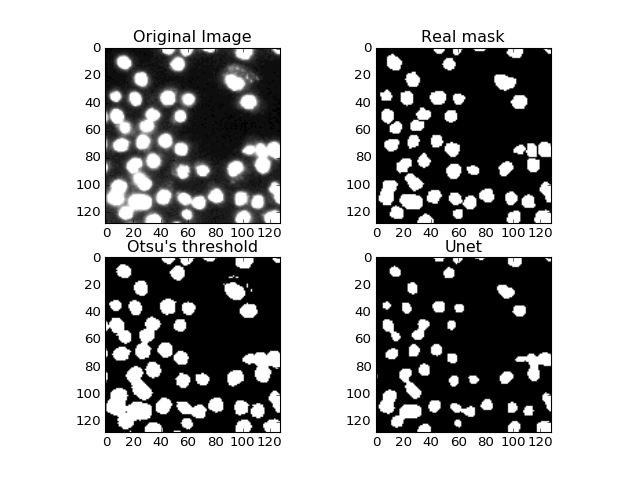

In [91]:
# Compare the real image, the real label, the Unet prediction and the Otsu's threshold
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.imshow(np.reshape(x[1]*255, (128, 128)), cmap="gray")
ax1.title.set_text('Original Image')
ax2.imshow(np.reshape((y[1]*255), (128, 128)), cmap="gray")
ax2.title.set_text('Real mask')
ax3.imshow(img_thr, cmap="gray")
ax3.title.set_text("Otsu's threshold")
ax4.imshow(np.reshape(pred2[1], (128, 128)), cmap="gray")
ax4.title.set_text("Unet")


The plots show the comparison between the original image, the label image that was
created from the data given, the mask created when using a classical method such 
as Otsu's threshold and the Unet segmentation. The Otsu's result seems that is able to
discern the cells that do not have other cells close to them but it confuses the saturated pixels for overlapping cells.
On the other hand the Unet finds the isolated cells but their sizes are much smaller than the mask.
Possibly a combination of methods could give us a better results.